**Table of contents**<a id='toc0_'></a>    
- [Прогнозирование риска сердечных приступов](#toc1_)    
  - [Загрузка данных](#toc1_1_)    
  - [Предобработка](#toc1_2_)    
    - [Train](#toc1_2_1_)    
    - [Test](#toc1_2_2_)    
    - [Выводы](#toc1_2_3_)    
  - [Исследовательский анализ](#toc1_3_)    
    - [Количественные признаки](#toc1_3_1_)    
    - [Категориальные признаки](#toc1_3_2_)    
    - [Таргет](#toc1_3_3_)    
  - [Отбор признаков и подготовка пайплана](#toc1_4_)    
  - [Обучение модели и подбор гиперпараметров](#toc1_5_)    
  - [Анализ важности признаков](#toc1_6_)    
  - [Оценка качества модели](#toc1_7_)    
  - [Получение предсказаний](#toc1_8_)    
  - [Общий вывод](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Прогнозирование риска сердечных приступов](#toc0_)

## <a id='toc1_1_'></a>[Загрузка данных](#toc0_)

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             precision_recall_curve, 
                             classification_report, 
                             f1_score, 
                             accuracy_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import Counter
import shap
import joblib

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 42

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
df_train = pd.read_csv('../data/heart_train.csv')
df_test = pd.read_csv('../data/heart_test.csv')

In [4]:
df_train.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [5]:
df_test.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


## <a id='toc1_2_'></a>[Предобработка](#toc0_)

### <a id='toc1_2_1_'></a>[Train](#toc0_)

Приведем названия столбцов к нижнему змеиному регистру

In [6]:
df_train.columns = df_train.columns.str.replace(' ', '_').str.lower()
df_train.columns

Index(['unnamed:_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk_(binary)', 'blood_sugar',
       'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

Переименуем название таргета и уберем в названии столбца прочерк

In [7]:
df_train.rename(columns=
                {
                    'ck-mb': 'ck_mb',
                    'heart_attack_risk_(binary)': 'heart_attack_risk'
                }
                , inplace=True)
df_train.columns

Index(['unnamed:_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk', 'blood_sugar', 'ck_mb',
       'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

Используем функцию, которая покажет основную информация о датасете

In [8]:
def df_info(df):
    df_ = pd.DataFrame(
        index = df.columns,
        data = {
            "dtype": [df[col].dtype for col in df.columns],
            "not_na": [df[col].notna().sum() for col in df.columns],
            "nan": [df[col].isna().sum() for col in df.columns],
            "unique_count": [df[col].nunique() for col in df.columns],
            "unique_values": [df[col].unique() for col in df.columns]
        })
    print(f' Размер датафрейма: {df.shape}')
    print(f' Кол-во строк-дубликатов: {df.duplicated().sum()}')
    return df_

In [9]:
df_info(df_train)

 Размер датафрейма: (8685, 28)
 Кол-во строк-дубликатов: 0


,dtype,not_na,nan,unique_count,unique_values
unnamed:_0,int64,8685,0,8685,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
age,float64,8685,0,77,"[0.3595505617977527, 0.2022471910112359, 0.606..."
cholesterol,float64,8685,0,282,"[0.732142857142857, 0.325, 0.8607142857142855,..."
heart_rate,float64,8685,0,87,"[0.074243813015582, 0.0476626947754353, 0.0559..."
diabetes,float64,8442,243,2,"[1.0, 0.0, nan]"
family_history,float64,8442,243,2,"[1.0, 0.0, nan]"
smoking,float64,8442,243,2,"[1.0, 0.0, nan]"
obesity,float64,8442,243,2,"[1.0, 0.0, nan]"
alcohol_consumption,float64,8442,243,2,"[1.0, 0.0, nan]"
exercise_hours_per_week,float64,8685,0,7933,"[0.5355049297181428, 0.068689995709055, 0.9440..."


Удалим ненужный признак `unknown:_0`, обозначим за индекс столбец `id`

In [10]:
df_train = df_train.set_index('id').drop('unnamed:_0', axis=1)
df_train.head()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302
9287,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767
5379,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930
8222,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442
4047,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860


В датафрейме встретились пропуски, причем их по 243 во многих признаках. Выведем строки с пропусками.

In [11]:
df_train[df_train.diabetes.isna()]

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
9528,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814
9640,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209
9515,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558
9491,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163
9448,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9455,0.719101,0.49978,0.049496,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.138340,0.004034,0.003204,1.0,0.548387,0.558140
9506,0.651685,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.239130,0.055790,0.060783,1.0,0.729032,0.779070
9474,0.651685,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.276680,0.008673,0.150403,1.0,0.606452,0.790698


In [12]:
print(f'Строки с пропусками составлют {df_train.diabetes.isna().sum() / df_train.age.count():.2%} от всего датасета.')

Строки с пропусками составлют 2.80% от всего датасета.


Удалим строки с пропусками

In [13]:
df_train = df_train[~df_train.diabetes.isna()]

In [14]:
gender_changes = {
    'Male': 1,
    'Female': 0
}

df_train.gender = df_train.gender.map(gender_changes)
df_train.gender.value_counts()

gender
1    5882
0    2560
Name: count, dtype: int64

In [15]:
df_train.columns.str.replace

<bound method StringMethods.replace of <pandas.core.strings.accessor.StringMethods object at 0x30ef56110>>

In [16]:
num_cols = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'sleep_hours_per_day',
    'blood_sugar',
    'ck_mb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
    'physical_activity_days_per_week'
]

target = ['heart_attack_risk']

cat_cols = [
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'previous_heart_problems',
    'medication_use',
    'gender',
    'stress_level',
    'diet',
]

In [17]:
df_train[cat_cols] = df_train[cat_cols].astype('int')
df_train[target] = df_train[target].astype('int')
df_info(df_train)

 Размер датафрейма: (8442, 26)
 Кол-во строк-дубликатов: 0


,dtype,not_na,nan,unique_count,unique_values
age,float64,8442,0,73,"[0.3595505617977527, 0.2022471910112359, 0.606..."
cholesterol,float64,8442,0,281,"[0.732142857142857, 0.325, 0.8607142857142855,..."
heart_rate,float64,8442,0,71,"[0.074243813015582, 0.0476626947754353, 0.0559..."
diabetes,int64,8442,0,2,"[1, 0]"
family_history,int64,8442,0,2,"[1, 0]"
smoking,int64,8442,0,2,"[1, 0]"
obesity,int64,8442,0,2,"[1, 0]"
alcohol_consumption,int64,8442,0,2,"[1, 0]"
exercise_hours_per_week,float64,8442,0,7932,"[0.5355049297181428, 0.068689995709055, 0.9440..."
diet,int64,8442,0,3,"[1, 2, 0]"


---

### <a id='toc1_2_2_'></a>[Test](#toc0_)

Приведем названия столбцов к нижнему змеиному регистру

In [18]:
df_test.columns = df_test.columns.str.replace(' ', '_').str.lower()
df_test.rename(columns={'ck-mb': 'ck_mb'}, inplace=True)
df_test.columns


Index(['unnamed:_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'blood_sugar', 'ck_mb', 'troponin', 'gender',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

Удалим ненужный признак `unknown:_0`, обозначим за индекс столбец `id`

In [19]:
df_test = df_test.set_index('id').drop('unnamed:_0', axis=1)
df_test.head()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,
7746,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093
4202,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860
6632,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070
4639,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814
4825,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349


In [20]:
df_info(df_test)

 Размер датафрейма: (966, 25)
 Кол-во строк-дубликатов: 0


,dtype,not_na,nan,unique_count,unique_values
age,float64,966,0,73,"[0.4943820224719101, 0.2247191011235955, 0.629..."
cholesterol,float64,966,0,266,"[0.2642857142857143, 0.9535714285714284, 0.092..."
heart_rate,float64,966,0,76,"[0.0623281393217231, 0.0824931255728689, 0.064..."
diabetes,float64,935,31,2,"[0.0, 1.0, nan]"
family_history,float64,935,31,2,"[1.0, 0.0, nan]"
smoking,float64,935,31,2,"[1.0, 0.0, nan]"
obesity,float64,935,31,2,"[1.0, 0.0, nan]"
alcohol_consumption,float64,935,31,2,"[1.0, 0.0, nan]"
exercise_hours_per_week,float64,966,0,924,"[0.3616179475374933, 0.9964834861899992, 0.995..."
diet,int64,966,0,4,"[2, 0, 1, 3]"


В датафрейме встретились пропуски, причем их по 31 во многих признаках. Выведем строки с пропусками.

In [21]:
df_test[df_test.diabetes.isna()]

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,
9613,0.370787,0.49978,0.034830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.181818,0.011843,0.000194,1.0,0.419355,0.441860
9471,0.573034,0.49978,0.043080,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.167984,0.011209,0.000971,1.0,0.722581,0.732558
9486,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.098814,0.036436,0.002233,1.0,0.387097,0.500000
9391,0.370787,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.199605,0.005970,0.006408,1.0,0.387097,0.220930
9579,0.483146,0.49978,0.028414,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.112648,0.013111,0.000680,1.0,0.419355,0.325581
9490,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.219368,1.000000,0.000583,1.0,0.335484,0.220930
9617,0.449438,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.264822,0.008906,0.002136,1.0,0.380645,0.186047
9465,0.325843,0.49978,0.029331,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.128458,0.002196,0.000583,0.0,0.387097,0.302326
9562,0.471910,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.083004,0.020218,0.000485,0.0,0.096774,0.441860


In [22]:
print(f'Строки с пропусками составлют {df_test.diabetes.isna().sum() / df_test.age.count():.2%} от всего датасета.')

Строки с пропусками составлют 3.21% от всего датасета.


Удалим строки с пропусками

In [23]:
df_test = df_test[~df_test.diabetes.isna()]

In [24]:
df_test.gender = df_test.gender.map(gender_changes)
df_test.gender.value_counts()

gender
1    650
0    285
Name: count, dtype: int64

In [25]:
df_test[cat_cols] = df_test[cat_cols].astype('int')
df_info(df_test)

 Размер датафрейма: (935, 25)
 Кол-во строк-дубликатов: 0


,dtype,not_na,nan,unique_count,unique_values
age,float64,935,0,73,"[0.4943820224719101, 0.2247191011235955, 0.629..."
cholesterol,float64,935,0,265,"[0.2642857142857143, 0.9535714285714284, 0.092..."
heart_rate,float64,935,0,71,"[0.0623281393217231, 0.0824931255728689, 0.064..."
diabetes,int64,935,0,2,"[0, 1]"
family_history,int64,935,0,2,"[1, 0]"
smoking,int64,935,0,2,"[1, 0]"
obesity,int64,935,0,2,"[1, 0]"
alcohol_consumption,int64,935,0,2,"[1, 0]"
exercise_hours_per_week,float64,935,0,923,"[0.3616179475374933, 0.9964834861899992, 0.995..."
diet,int64,935,0,3,"[2, 0, 1]"


---

### <a id='toc1_2_3_'></a>[Выводы](#toc0_)

- Пропуски обработаны
- Явных и неявных дуюликатов нет
- Названия признаков приведены к нижнему змеиному регистру
- Удален ненужный признак
- `id` перенесен в индекс
- Все признаки приведены к нужному типу данных
- Действия проделаны для тестовой и тренировочной выборок

## <a id='toc1_3_'></a>[Исследовательский анализ](#toc0_)

In [26]:
def cat_plot(data, col_list):
    L = len(col_list)
    ncol = 2
    nrow = int(np.ceil(L/ncol))
    remove_last = (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(18, 24), facecolor='#F6F5F4') 
    ax = ax.flatten()
    fig.subplots_adjust(top=0.95)
    if remove_last>0:
        ax.flat[-remove_last].set_visible(False)

    for col, i in zip(col_list, range(L)):
        sns.countplot(data=data, ax = ax[i], x=col, hue="heart_attack_risk")
        sns.despine(right=True)
        sns.despine(offset=0, trim=False)
        ax[i].set_xlabel(col, fontsize=20)
        ax[i].set_ylabel("count", fontsize=20)
        for p in ax[i].patches:
            height = p.get_height()
            if height > 0:
                ax[i].text(
                    p.get_x() + p.get_width() / 2.,
                    height + 0.5,
                    f'{int(height)}',
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.5)
                )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('Distribution of Categorical Features' ,fontsize = 24)
    return plt.show()

def num_plot(data, col_list):
    L = len(col_list)
    ncol = 2
    nrow = int(np.ceil(L/ncol))
    remove_last = (nrow * ncol) - L
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(18, 24),facecolor='#F6F5F4')
    ax = ax.flatten()   
    fig.subplots_adjust(top=0.9)
    if remove_last>0:
        ax.flat[-remove_last].set_visible(False)

    for col, i in zip(col_list, range(L)):
        sns.kdeplot(data=data, ax=ax[i], x=col, hue="heart_attack_risk", multiple="stack") 
        sns.despine(ax=ax[i], right=True)
        sns.despine(ax=ax[i], offset=0, trim=False)
        ax[i].set_xlabel(col, fontsize=20)
        ax[i].set_ylabel("count", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
        
    plt.suptitle('Distribution of Numerical Features', fontsize = 24)
    return plt.show()

### <a id='toc1_3_1_'></a>[Количественные признаки](#toc0_)

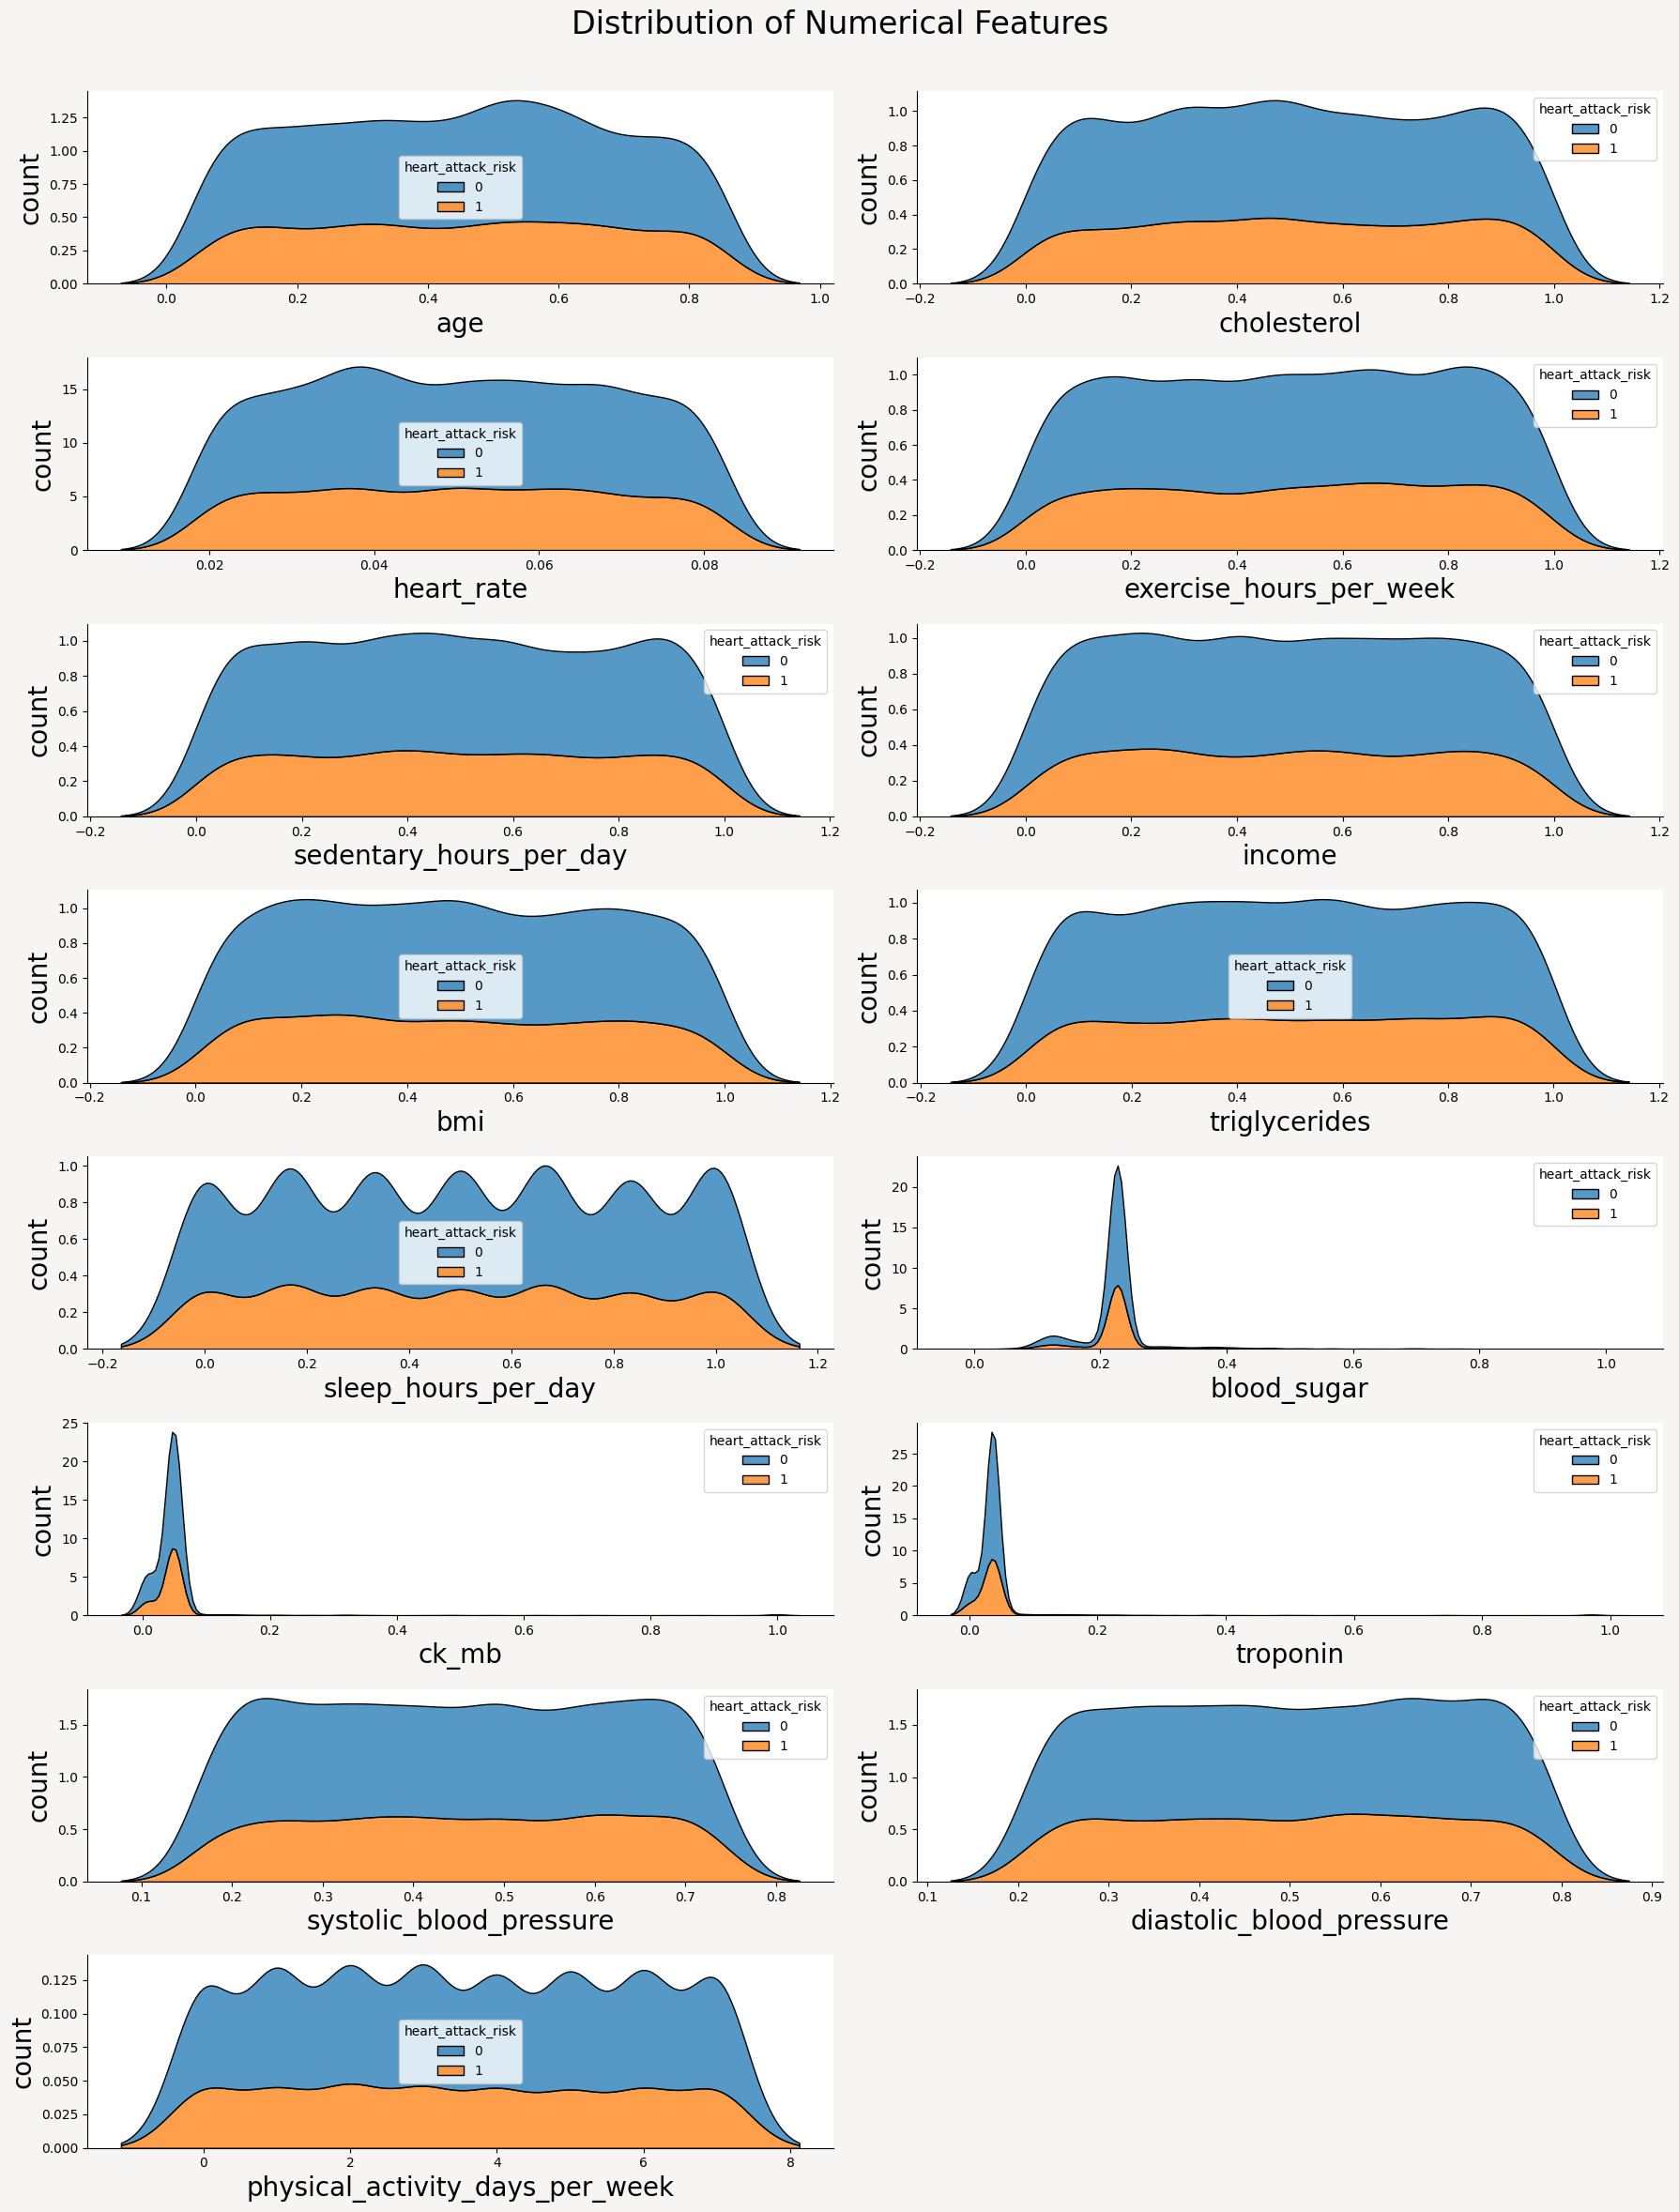

In [27]:
num_plot(df_train, num_cols)

Изучим странные распределения в признаках `ck_mb`, `troponin`, `blood_sugar`

In [28]:
df_train[['ck_mb', 'troponin', 'blood_sugar']].describe()

,ck_mb,troponin,blood_sugar
count,8442.000000,8442.000000,8442.000000
mean,0.047745,0.036867,0.227998
std,0.070399,0.059284,0.074623
min,0.000000,0.000000,0.000000
25%,0.048229,0.036512,0.227018
50%,0.048229,0.036512,0.227018
75%,0.048229,0.036512,0.227018
max,1.000000,1.000000,1.000000


Первый и третий квартили имеют одинаковые значения, зн при удалении выбросов по принципу +-1.5*IQR признаки будут иметь константные значения. Данные признаки не имеет смысла использовать.


Все остальные признаки будут отбираться эмпирическим путем.

### <a id='toc1_3_2_'></a>[Категориальные признаки](#toc0_)

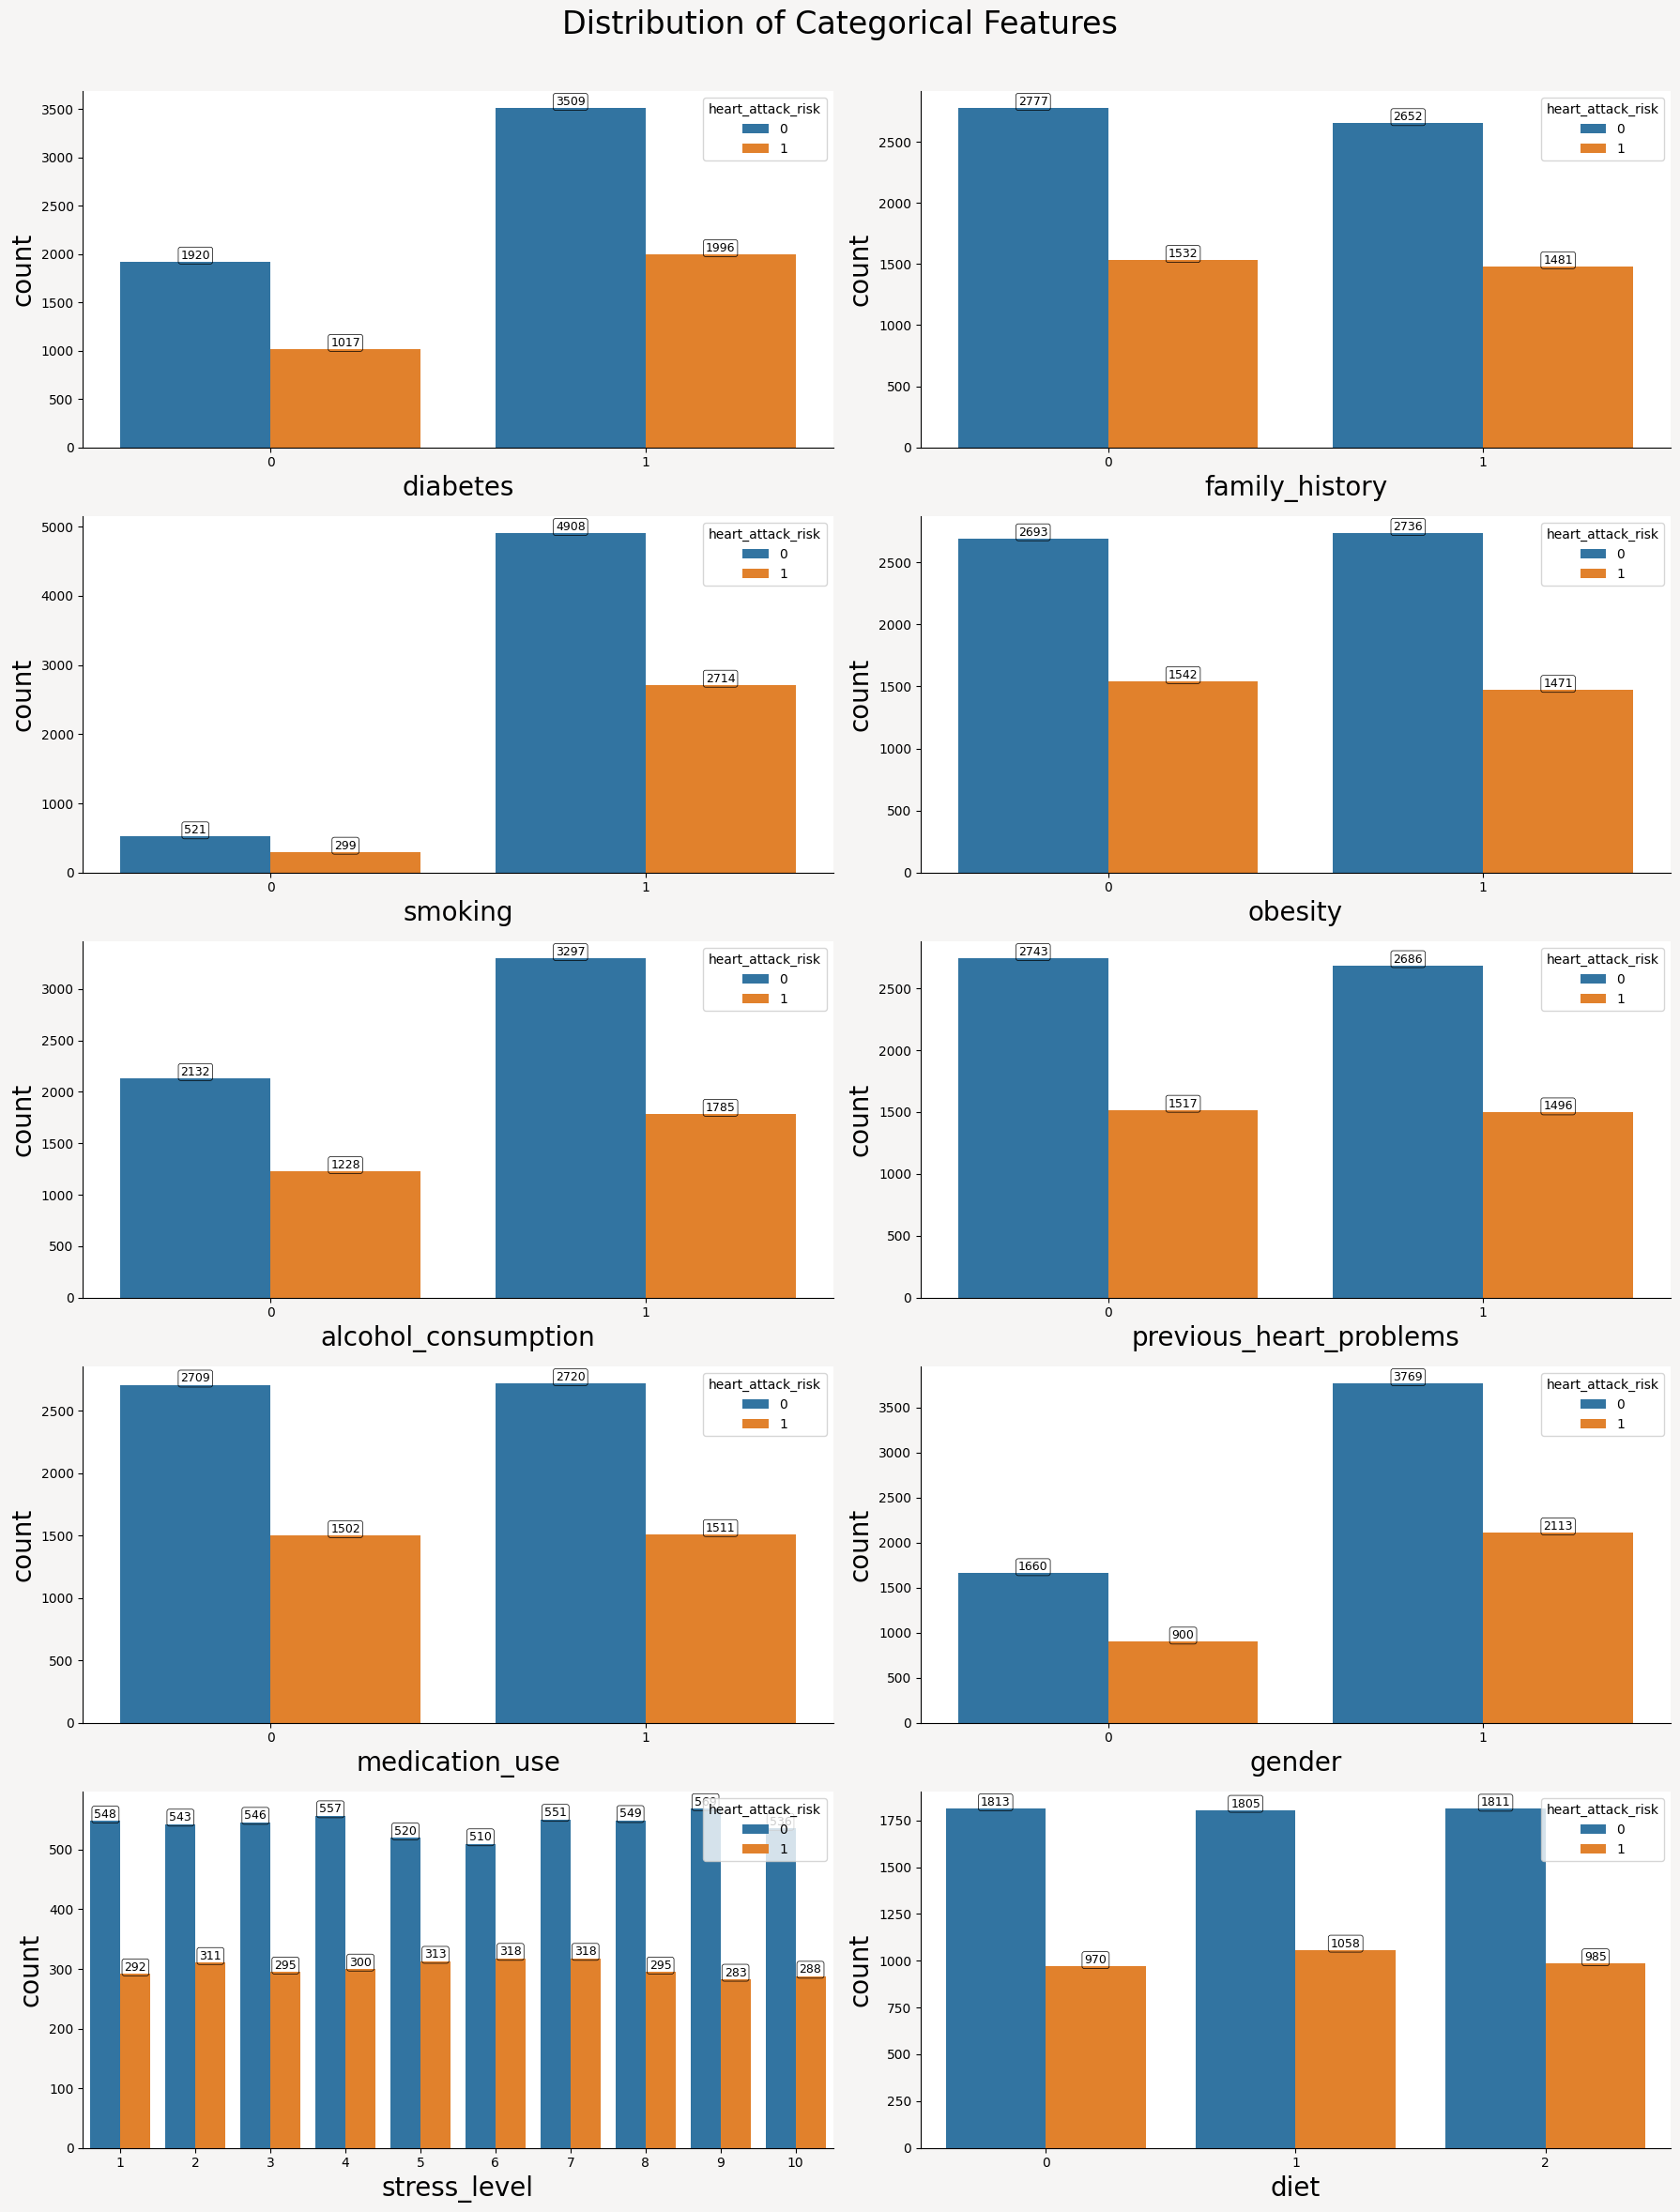

In [29]:
cat_plot(df_train, cat_cols)

### <a id='toc1_3_3_'></a>[Таргет](#toc0_)

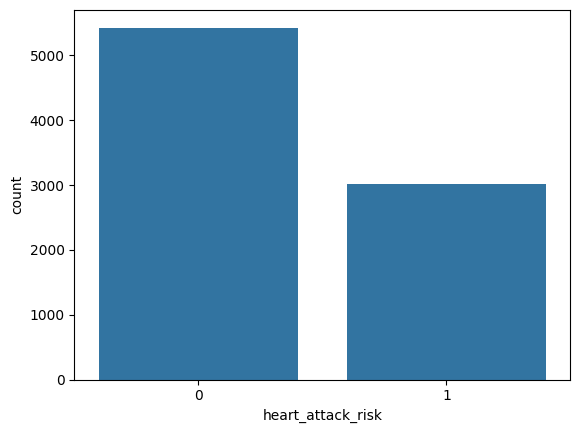

In [30]:
sns.countplot(data=df_train, x='heart_attack_risk')
plt.show()

## <a id='toc1_4_'></a>[Отбор признаков и подготовка пайплана](#toc0_)

In [31]:
to_drop = [
            #'cholesterol', # выжный признак
            #'bmi', # выжный признак
            #'systolic_blood_pressure', # выжный признак
            #'triglycerides', # выжный признак
            #'stress_level',
            #'previous_heart_problems', 
            #'diet',
            #'heart_rate',
            'diastolic_blood_pressure', 
            'gender',
            'smoking', # сильный дисбаланс классов - использовать не будем
            'sleep_hours_per_day', # не используем
            'exercise_hours_per_week', # не используем
            'alcohol_consumption', # не используем
            'physical_activity_days_per_week', # не используем
            'sedentary_hours_per_day', # не используем
            'heart_attack_risk', # таргет
            'medication_use', # не используем
            'age', # не используем
            'diabetes', # не используем
            'obesity', # не используем
            'family_history', # не используем
            'income', # не используем
            'blood_sugar', # не используем
            'ck_mb', # не используем
            'troponin', # не используем
            ]

num_cols_filtered = [col for col in num_cols if col not in to_drop]
ohe_cols = [col for col in cat_cols if col not in to_drop]
#ord_cols = [col for col in multi_cols if col not in to_drop]

X = df_train.drop(columns=to_drop)
y = df_train.heart_attack_risk

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE, stratify=y
)


In [32]:
def create_phik_matrix(df, interval_cols):
    phik_overview = phik_matrix(df, interval_cols=interval_cols) 
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Blues',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(20, 15)
    )

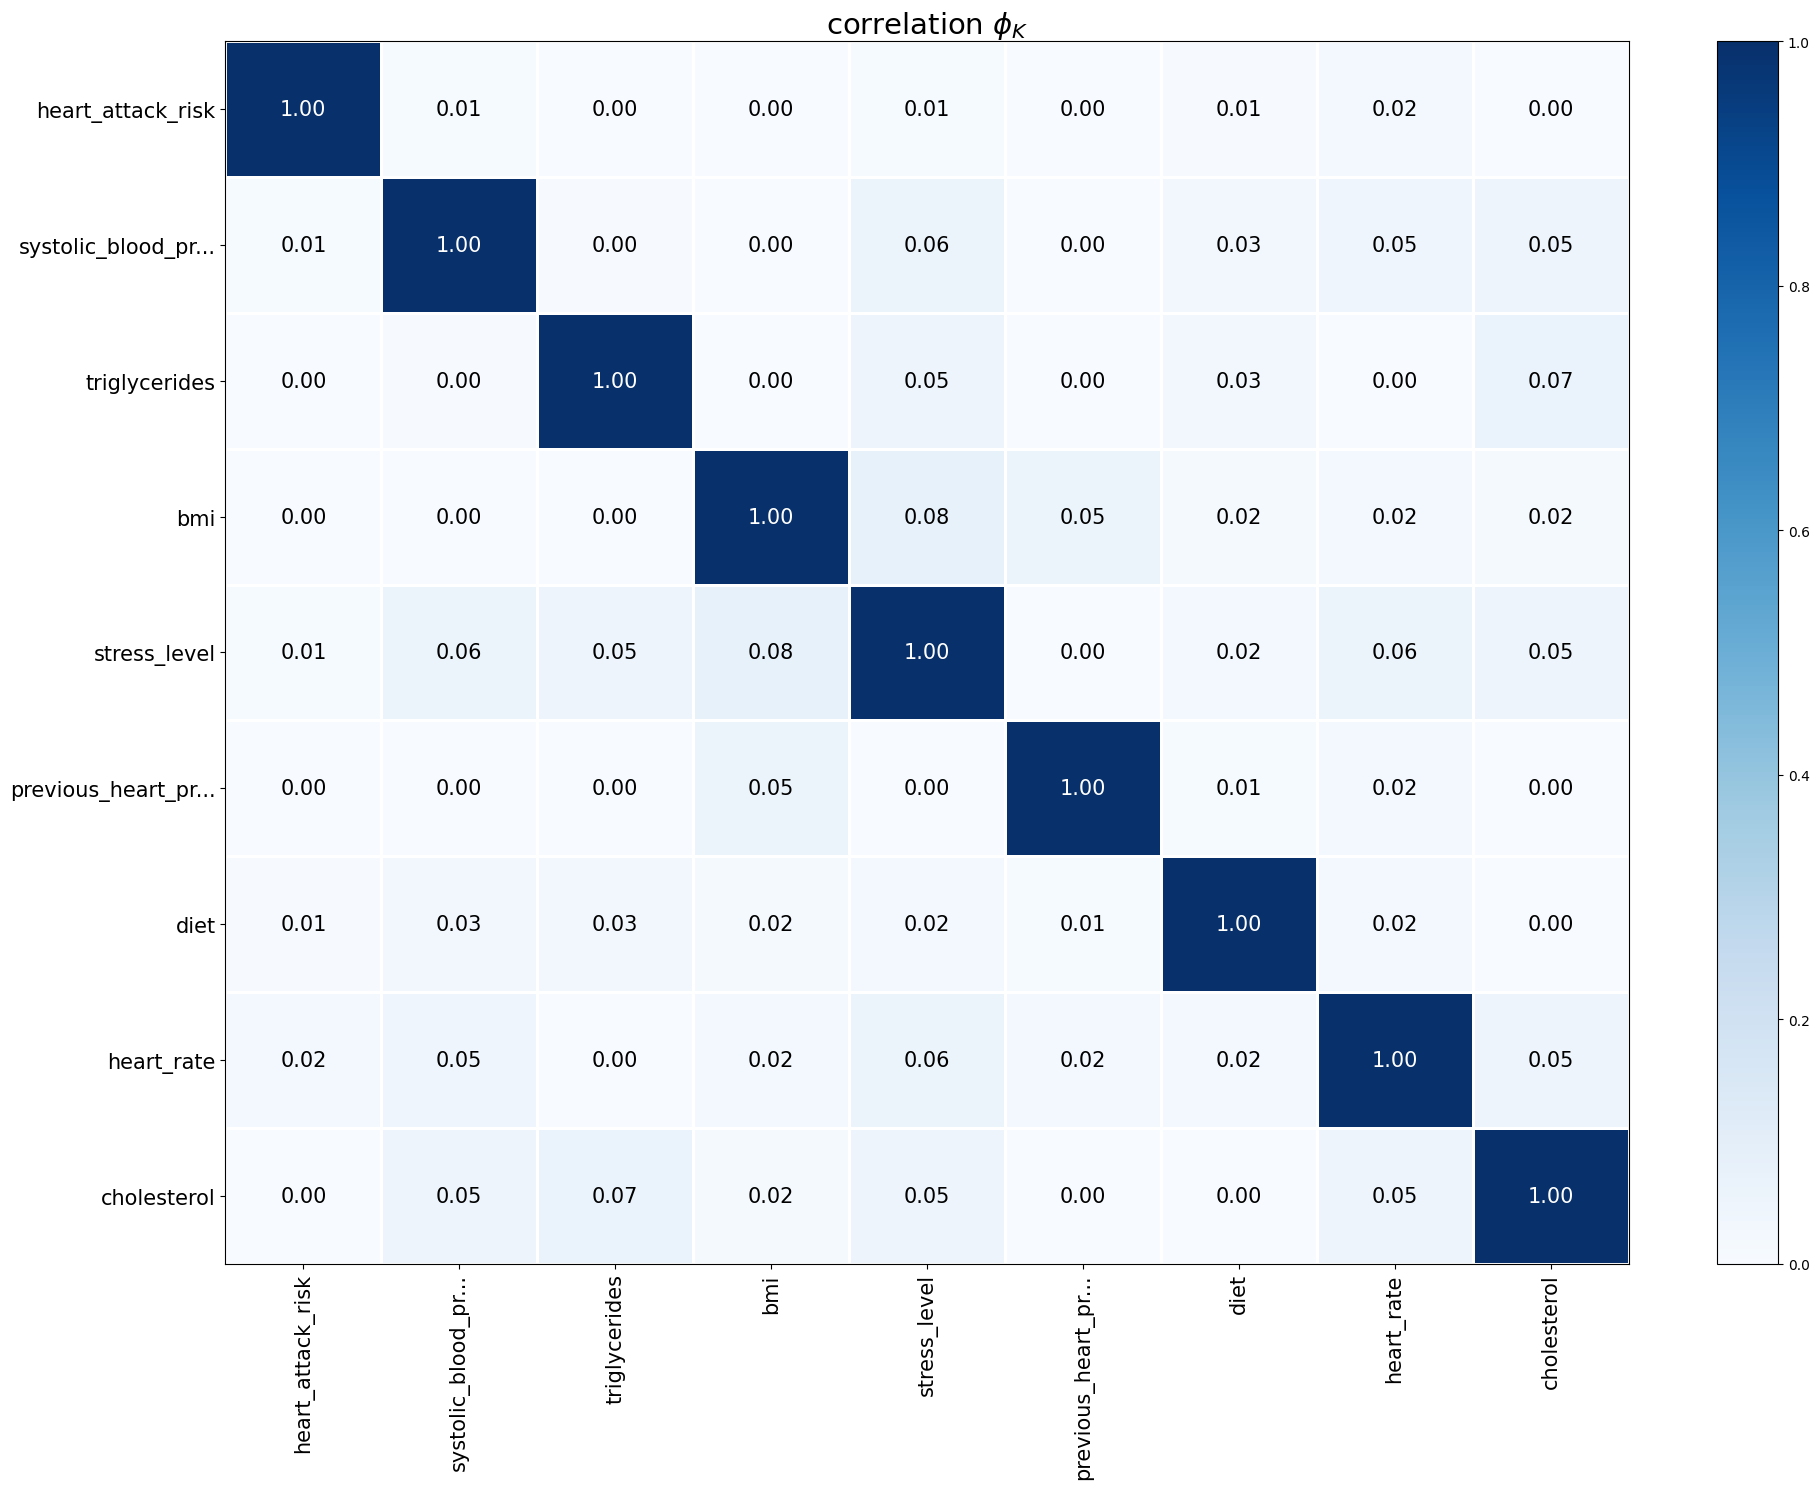

In [33]:
create_phik_matrix(
    X_train.merge(y_train, on='id'),
    interval_cols = num_cols_filtered
)

In [34]:
# One-Hot Encoding pipeline
ohe_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

# Ordinal Encoding pipeline
"""ord_pipe = Pipeline(steps=[
    ('ord', OrdinalEncoder(categories=[
        ['0', '1', '2'], # diet
        ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], # stress_level
        #['0', '1', '2', '3', '4', '5', '6', '7'] # physical_activity_days_per_week
    ]))
])"""

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe, ohe_cols),
    #('ord', ord_pipe, ord_cols)
], remainder='passthrough')

pipe_final = ImbPipeline(
    [
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        #('undersample', RandomUnderSampler(random_state=RANDOM_STATE)),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [35]:
# До SMOTE
print("Before:", Counter(y_train))

# Промежуточно вызовем SMOTE вручную (как в пайплайне)
X_tr = preprocessor.fit_transform(X_train)
X_resampled, y_resampled = SMOTE(random_state=RANDOM_STATE).fit_resample(X_tr, y_train)

print("After:", Counter(y_resampled))

Before: Counter({0: 4886, 1: 2711})
After: Counter({0: 4886, 1: 4886})


## <a id='toc1_5_'></a>[Обучение модели и подбор гиперпараметров](#toc0_)

In [36]:
"""params = [
    {
        'models': [SVC(class_weight='balanced', random_state=RANDOM_STATE, probability=True)], 
        'models__C': [0.1, 1, 100], # сила регуляризации
        'models__kernel': ['linear', 'rbf', 'sigmoid'], # тип ядра
    }
]"""

"params = [\n    {\n        'models': [SVC(class_weight='balanced', random_state=RANDOM_STATE, probability=True)], \n        'models__C': [0.1, 1, 100], # сила регуляризации\n        'models__kernel': ['linear', 'rbf', 'sigmoid'], # тип ядра\n    }\n]"

In [37]:
"""params = [{
        'models': [SVC(class_weight='balanced', kernel='poly', random_state=RANDOM_STATE, probability=True)], 
        'models__C': [0.01, 1,100], # сила регуляризации
        'models__degree': [2], # степень полиномиального ядра
    }
]"""

"params = [{\n        'models': [SVC(class_weight='balanced', kernel='poly', random_state=RANDOM_STATE, probability=True)], \n        'models__C': [0.01, 1,100], # сила регуляризации\n        'models__degree': [2], # степень полиномиального ядра\n    }\n]"

In [38]:
"""params = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [10, 20, None], # глубина дерева
        'models__min_samples_leaf': range(2, 30, 3), # минимум образцов для разбиения
        'models__min_samples_split': range(2, 30, 3), # минимум образцов в листе
    },
    
]"""

"params = [\n    # словарь для модели DecisionTreeClassifier()\n    {\n        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],\n        'models__max_depth': [10, 20, None], # глубина дерева\n        'models__min_samples_leaf': range(2, 30, 3), # минимум образцов для разбиения\n        'models__min_samples_split': range(2, 30, 3), # минимум образцов в листе\n    },\n    \n]"

In [39]:
"""params = [
    {
        'models': [LogisticRegression(class_weight='balanced', solver = 'liblinear', random_state=RANDOM_STATE)],
        'models__C': [0.01, 0.1, 1, 10, 100], # сила регуляризации
        'models__penalty': ['l1', 'l2'] # тип регуляризации
    }]"""

"params = [\n    {\n        'models': [LogisticRegression(class_weight='balanced', solver = 'liblinear', random_state=RANDOM_STATE)],\n        'models__C': [0.01, 0.1, 1, 10, 100], # сила регуляризации\n        'models__penalty': ['l1', 'l2'] # тип регуляризации\n    }]"

In [40]:
params = {
    'models': [KNeighborsClassifier()],
    'models__n_neighbors': range(1, 7),
    'models__weights': ['uniform', 'distance'],
    'models__p': [1, 2],  # Manhattan (1) vs Euclidean (2)
    'models__metric': ['minkowski', 'manhattan', 'euclidean', 'chebyshev']
}

In [41]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=params, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise'
    )

grid.fit(X_train, y_train)

print('Лучшая модель и ее параметры:', grid.best_params_)
print('Score:', grid.best_score_)

Лучшая модель и ее параметры: {'models': KNeighborsClassifier(), 'models__metric': 'chebyshev', 'models__n_neighbors': 6, 'models__p': 1, 'models__weights': 'distance'}
Score: 0.589147523220426


In [42]:
pd.DataFrame(grid.cv_results_).sort_values(by = 'rank_test_score').set_index('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__metric,param_models__n_neighbors,param_models__p,param_models__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,
1,0.033751,0.010159,0.196140,0.043654,KNeighborsClassifier(),chebyshev,6,2,distance,"{'models': KNeighborsClassifier(), 'models__me...",0.597078,0.598937,0.572009,0.575886,0.601829,0.589148,0.012563
1,0.030056,0.007687,0.275574,0.022419,KNeighborsClassifier(),chebyshev,6,1,distance,"{'models': KNeighborsClassifier(), 'models__me...",0.597078,0.598937,0.572009,0.575886,0.601829,0.589148,0.012563
3,0.043374,0.012107,0.221883,0.022043,KNeighborsClassifier(),manhattan,6,1,distance,"{'models': KNeighborsClassifier(), 'models__me...",0.598123,0.591750,0.572728,0.566280,0.608497,0.587476,0.015750
3,0.100441,0.039542,0.228453,0.061895,KNeighborsClassifier(),minkowski,6,1,distance,"{'models': KNeighborsClassifier(), 'models__me...",0.598123,0.591750,0.572728,0.566280,0.608497,0.587476,0.015750
3,0.031424,0.009444,0.191833,0.035774,KNeighborsClassifier(),manhattan,6,2,distance,"{'models': KNeighborsClassifier(), 'models__me...",0.598123,0.591750,0.572728,0.566280,0.608497,0.587476,0.015750


## <a id='toc1_6_'></a>[Анализ важности признаков](#toc0_)

In [43]:
X_transformed = grid.best_estimator_.named_steps['preprocessor'].transform(X_train)

explainer = shap.KernelExplainer(
    model=lambda x: grid.best_estimator_.named_steps['models'].predict_proba(x)[:, 1], 
    data = shap.sample(X_transformed, 1),
    feature_names = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
)

shap_values = explainer(X_transformed[:1000])

  0%|          | 0/1000 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


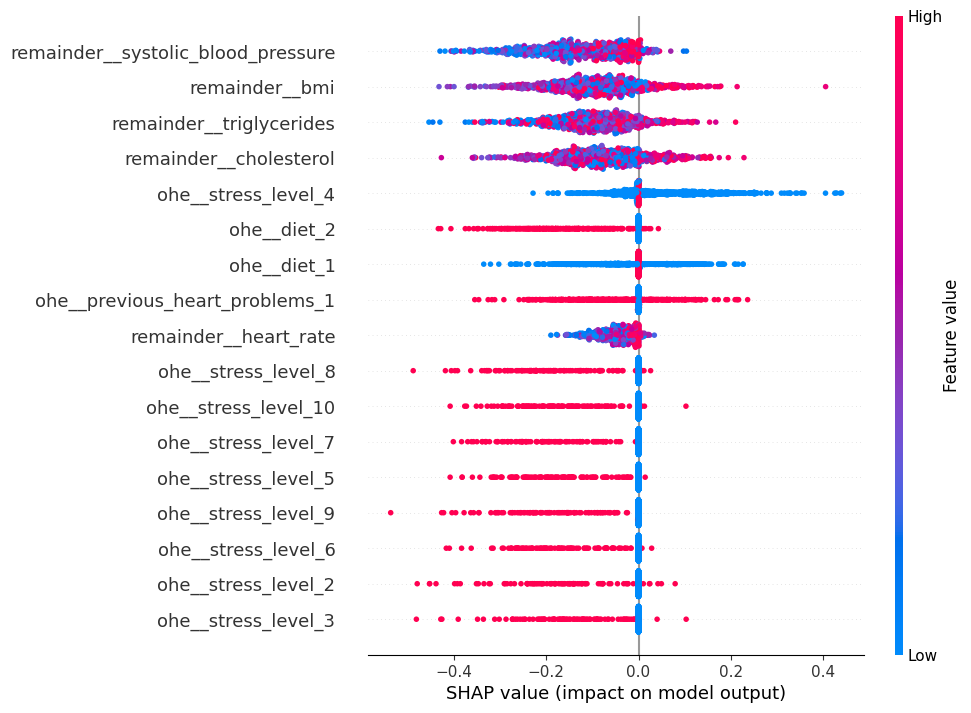

In [44]:
shap.plots.beeswarm(shap_values, max_display=17)

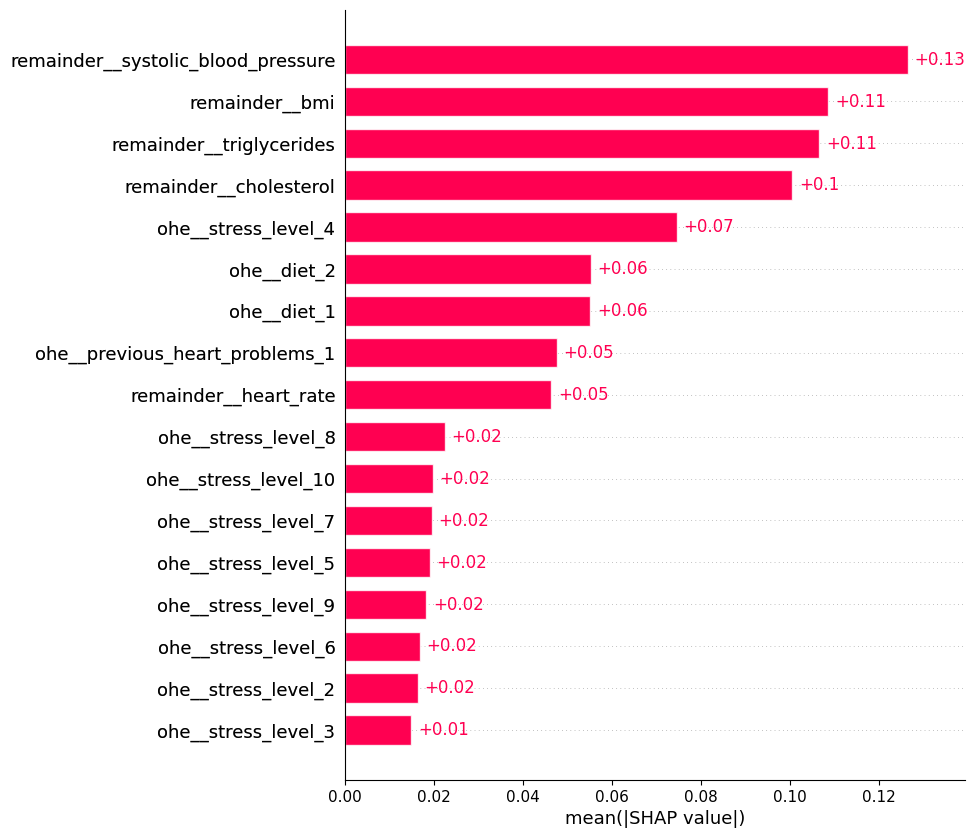

In [45]:
shap.plots.bar(shap_values, max_display=17)

## <a id='toc1_7_'></a>[Оценка качества модели](#toc0_)

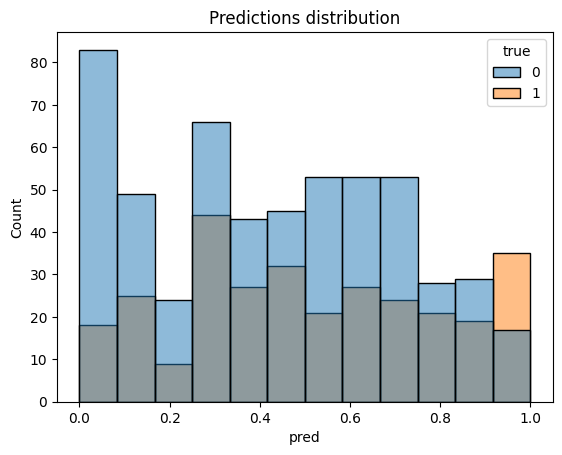

In [46]:
probs = grid.best_estimator_.predict_proba(X_test)[:,1]  # вероятность класса 1

comparisson = pd.DataFrame({
        'pred': probs,
        'true': y_test
    })

sns.histplot(data = comparisson, x='pred', hue='true')
plt.title('Predictions distribution')
plt.show()

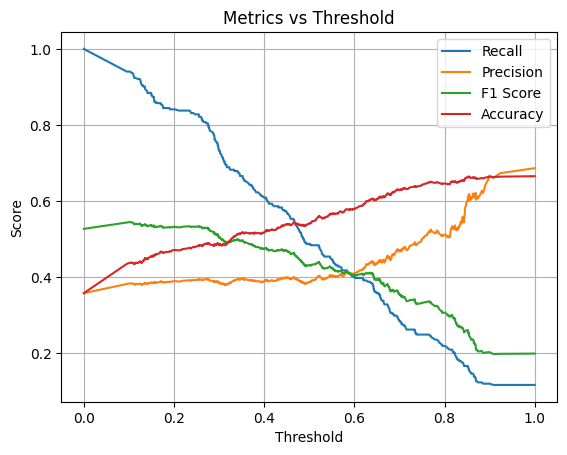

In [47]:
# Фактические метки классов
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Инициализация списков для F1 и Accuracy
f1_scores = []
accuracies = []

# Проход по всем порогам
for thresh in thresholds:
    preds = (probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, preds))
    accuracies.append(accuracy_score(y_test, preds))

# Построение графика
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [48]:
def show_cm(probs, y_true, threshold=0.5):
    y_pred = (probs >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62       543
           1       0.39      0.49      0.43       302

    accuracy                           0.54       845
   macro avg       0.53      0.53      0.52       845
weighted avg       0.57      0.54      0.55       845



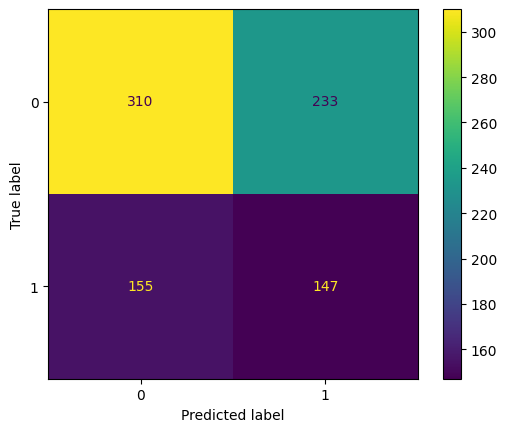

In [66]:
show_cm(probs, y_test, threshold=0.5)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       543
           1       0.36      1.00      0.53       302

    accuracy                           0.36       845
   macro avg       0.18      0.50      0.26       845
weighted avg       0.13      0.36      0.19       845



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


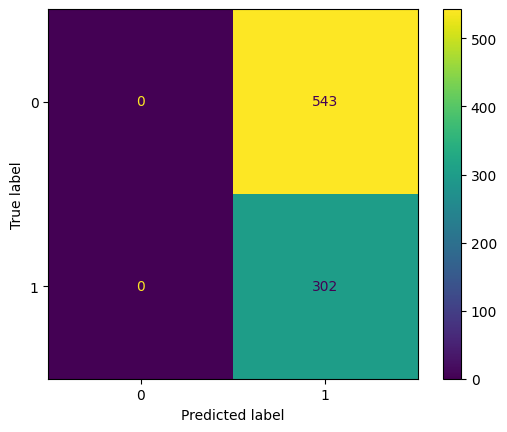

In [67]:
dummy = DummyClassifier(random_state=RANDOM_STATE, strategy='constant', constant=1)
dummy.fit(X_train, y_train)

show_cm(dummy.predict(X_test), y_test)

Сохранение модели для последующего использования:

In [57]:
joblib.dump(grid.best_estimator_, '../model.pkl')

['../model.pkl']

## <a id='toc1_8_'></a>[Получение предсказаний](#toc0_)

In [51]:
threshold = 0.5

df_test['predictions'] = (grid.best_estimator_.predict_proba(df_test)[:, 1] >= threshold).astype('int')

final_answer = df_test['predictions'].reset_index()

print(final_answer.shape)
final_answer.head()


(935, 2)


,id,predictions
0,7746,0
1,4202,1
2,6632,1
3,4639,0
4,4825,1


Сохранение предсказаний на тестовой выборке в CSV формате для последующей проверки:

In [62]:
final_answer.to_csv("../test_predictions.csv", index=False)

Порядок входных признаков и разброс значений для настройки HTML формы:

In [61]:
print(grid.best_estimator_.feature_names_in_)

df_train[grid.best_estimator_.feature_names_in_].describe()

['cholesterol' 'heart_rate' 'diet' 'previous_heart_problems'
 'stress_level' 'bmi' 'triglycerides' 'systolic_blood_pressure']


,cholesterol,heart_rate,diet,previous_heart_problems,stress_level,bmi,triglycerides,systolic_blood_pressure
count,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000
mean,0.501108,0.050194,1.001540,0.495380,5.493367,0.496831,0.505539,0.451955
std,0.288785,0.018442,0.812981,0.500008,2.867862,0.286599,0.290412,0.170187
min,0.000000,0.018332,0.000000,0.000000,1.000000,0.000000,0.000000,0.161290
25%,0.260714,0.034830,0.000000,0.000000,3.000000,0.247935,0.257143,0.303226
50%,0.496429,0.050412,1.000000,0.000000,5.000000,0.490801,0.507792,0.451613
75%,0.750000,0.065995,2.000000,1.000000,8.000000,0.744399,0.758442,0.600000
max,1.000000,0.082493,2.000000,1.000000,10.000000,1.000000,1.000000,0.741935


## <a id='toc1_9_'></a>[Общий вывод](#toc0_)

Цель: создать классификатор, определяющий риск сердечных приступов

Задачи: 
- преобработка данных
- исследовательский аналих
- корреляуионный анализ
- анализ важности и отбор признаков
- написание пайплайна
- проверка качества модели
- получение предсказаний на тестовой выборке

Выводы:
- Отдельно каждый признак имеет низкую корреляцию с таргетом, коэффициент phik не превышал 0.06. 
- Некоторые признаки оказались бесполезными уже на этапе исследовательского анализа. Фичи `ck_mb`, `troponin`, `blood_sugar` имеют константные значения в интервале от Q1 до Q3. Другой пример - `smoking`, более 90% пациентов - курящие, причем в разрезе по таргету обе группы крущие и нет - одиннаковые.
- Изучение качества модели проводилось на валидационной выборке. Она составляет 10% от изначальной даты. 
- Без подбора гиперпараметров и использования особых приемов подготовки данных метрика ROC-AUC не превышала 0.52 у всех следующих моделей: KNN, LogReg, SVC, DecTree. Использование SMOTE апсемплинга и подбор гиперпараметров на модели KNN получилось поднять score до 0.59.
- Сравнение со случайным классификатором показало небольшое преисущество разработанного решения: accuracy 0.36 против 0.54.
- Предсказания на тестовой выборке сохранены в файле `test_predictions.csv`.
- Модель сохренена в формате pkl и располагается в корневой папке `model.pkl`.
